### Deep Learning for hourly load forecasting of the building in Thane, Mumbai

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

/home/varat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load raw data
df = pd.read_csv('hourly_load_mumbai.csv', header=None)
# numpy array
df_array = df.values
# Daily load
daily_load = [df_array[i,:] for i in range(0, len(df)) if i%24 == 0] # list_daily_load changed to daily_load
# hourly load (23 hours for each day)
hourly_load = [df_array[i,1]/100000 for i in range(0, len(df)) if i%24 != 0] # list_hourly_load changead as above
# the length of the sequence for predicting the future value
seq_len = 23
load = []   # matrix changed simply to load

for i in range(len(hourly_load) - seq_len + 1):
        load.append(hourly_load[i:i + seq_len])
final_load = load     # matrix_load changed to final_load

# Shift all data by mean
final_load = np.array(final_load)
load_mean = final_load.mean()  # Shifted_value changed to load_mean
final_load -= load_mean       # This is after removing all the means from the original data
print('Data shape:', final_load.shape)
df_array

Data shape: (4877, 23)


array([['1/1/2016', 1311693.43],
       ['1/1/2016 1:00', 1240583.19],
       ['1/1/2016 2:00', 1185502.49],
       ...,
       ['7/31/2016 21:00', 1427712.44],
       ['7/31/2016 22:00', 1315301.39],
       ['7/31/2016 23:00', 1204251.82]], dtype=object)

##### Split dataset: 90% for training and remaining 10% for testing

In [3]:
train_row = int(round(0.75 * final_load.shape[0]))
train_set = final_load[:train_row,:]

# Shuffle the training set (but do not shuffle the rest set)
np.random.shuffle(train_set)

# The training Set
X_train = train_set[:,:-1]
# The last column is the true value to compute the mean-squared-error loss
Y_train = train_set[:,-1]

# The test set
X_test = final_load[train_row:, :-1]
Y_test = final_load[train_row:, -1]

In [4]:
# Input to LSTM layer needs to have the shape of (number of samples, dimension of each element)
# Arranging the dimensions of inputs in order to feed into LSTM networks

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Build the model

In [5]:
# Model Definition
model = Sequential()

# Layer 1: LSTM
model.add(LSTM(input_dim =1, output_dim = 50, return_sequences=True)) #activation by default=tanh
model.add(Dropout(0.2))

# Layer 2: LSTM
model.add(LSTM(output_dim=100, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Dense
model.add(Dense(output_dim=1, activation='linear'))

#Compile the model
model.compile(loss='mse', optimizer='adam' )  # optimizer='rmsprop'

/home/varat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/varat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  """
/home/varat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
  if __name__ == '__main__':
/home/varat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  del sys.path[0]


### Train the model

In [6]:
model.fit(X_train, Y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

/home/varat/anaconda3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3475 samples, validate on 183 samples
Epoch 1/50
3475/3475 [==============================] - 4s 1ms/step - loss: 7.9799 - val_loss: 5.8805
Epoch 2/50
3475/3475 [==============================] - 2s 499us/step - loss: 6.1906 - val_loss: 5.4110
Epoch 3/50
3475/3475 [==============================] - 2s 513us/step - loss: 5.5766 - val_loss: 4.5324
Epoch 4/50
3475/3475 [==============================] - 2s 541us/step - loss: 4.7423 - val_loss: 3.8810
Epoch 5/50
3475/3475 [==============================] - 2s 537us/step - loss: 3.8201 - val_loss: 2.8953
Epoch 6/50
3475/3475 [==============================] - 2s 547us/step - loss: 2.7819 - val_loss: 2.1540
Epoch 7/50
3475/3475 [==============================] - 2s 617us/step - loss: 2.2321 - val_loss: 1.7900
Epoch 8/50
3475/3475 [==============================] - 2s 593us/step - loss: 1.8370 - val_loss: 1.4028
Epoch 9/50
3475/3475 [==============================] - 2s 547us/step - loss: 1.5184 - val_loss: 1.1201
Epoch 10/50
3475/34

### Evaluate the result

In [7]:
mse_test = model.evaluate(X_test, Y_test, verbose=1)
print('\n mean squared error(MSE) on the test data set is %.3f over %d test samples.' %(mse_test, len(Y_test)))

1219/1219 [==============================] - 0s 366us/step

 mean squared error(MSE) on the test data set is 0.422 over 1219 test samples.


###  Get the predicted values

In [8]:
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples, 1))

### Plot the results

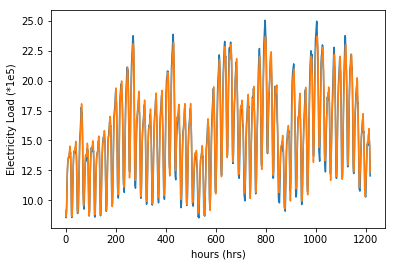

In [9]:
fig= plt.figure()
plt.plot(Y_test + load_mean)
plt.plot(predicted_values + load_mean)
plt.xlabel('hours (hrs)')
plt.ylabel('Electricity Load (*1e5)')
plt.show()

# Save the plot into a jpg file
fig.savefig('Forecasted_Load_Results.jpg', bbox_inches='tight')

# Save the results into txt file
test_result = np.vstack((predicted_values + load_mean))
np.savetxt('Forecasted_Load__Results.txt', test_result)